In [1]:
from __future__ import annotations

import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gemdat import Trajectory, plots
from gemdat.io import load_known_material
from gemdat.transitions import dijkstra_path, direct_path, find_best_perc_path
from gemdat.volume import trajectory_to_volume

In [2]:
# Select the trajectory to load
#trajectory = Trajectory.from_vasprun(Path('tests/data/short_simulation/vasprun_long.xml'),
#                                     exception_on_bad_xml=False)
trajectory = Trajectory.from_vasprun(
    Path('tests/data/short_simulation/vasprun.xml'))
print('Loading ok', flush=True)
type_to_select = 'Li'
diff_trajectory = trajectory.filter(type_to_select)

# Load the structure
structure = load_known_material('argyrodite', supercell=(2, 1, 1))

Loading ok


In [3]:
%matplotlib widget

# Resolution is the minimum size of the voxels in Angstrom
diff_volume = trajectory_to_volume(diff_trajectory, resolution=0.5)

# density plot also represents the energy
plots.density(diff_volume, structure, as_probability=False)

F = diff_volume.get_free_energy(kBT=trajectory.metadata['temperature'])
# *Notice that there are points where it is numerically impossible to find moble atoms
# In such points the free energy is Inf and it can cause numerical instabilities

/home/simone/Dropbox/eScience_projects/GEMDAT/src/gemdat/volume.py:298: RuntimeWarning:

divide by zero encountered in log



In [4]:
# Select a start and and end point to get a single path

# (option 1) Manually select start and end points
start_point = (0, 10, 5)
end_point = (7, 3, 2)

# (option 2) Consider as candidates all the sites where F is smaller than Fmax
Fmax = 1e6
indices = np.where(F < Fmax)
candidates = list(zip(*indices))
start_point = random.choice(candidates)
end_point = random.choice(candidates)

# (option 3) Select two peaks
peaks = diff_volume.find_peaks()
start_point = tuple(random.choice(peaks))
end_point = tuple(random.choice(peaks))

print(f'Path from {start_point} to {end_point}')

Path from (6, 12, 18) to (35, 15, 0)


In [5]:
# Calculate the path between two points

path, path_energy = dijkstra_path(F,
                                  start_point,
                                  end_point,
                                  max_energy_threshold=1e10)
print('Dijkstra path: ', path)
if path is not None:
    print("Total Energy Required:", sum(path_energy))

dpath, dpath_energy = direct_path(F, start_point, end_point)
print('Direct path: ', dpath)
if dpath is not None:
    print("Total Energy Required:", sum(dpath_energy))

Dijkstra path:  [(6, 12, 18), (5, 13, 18), (4, 14, 18), (3, 15, 18), (2, 15, 18), (1, 15, 17), (0, 15, 18), (38, 15, 0), (37, 15, 1), (36, 15, 0), (35, 15, 0)]
Total Energy Required: 52258.987979344834
Direct path:  [(6, 12, 18), (7, 13, 17), (8, 14, 16), (9, 15, 15), (10, 15, 14), (11, 15, 13), (12, 15, 12), (13, 15, 11), (14, 15, 10), (15, 15, 9), (16, 15, 8), (17, 15, 7), (18, 15, 6), (19, 15, 5), (20, 15, 4), (21, 15, 3), (22, 15, 2), (23, 15, 1), (24, 15, 0), (25, 15, 0), (26, 15, 0), (27, 15, 0), (28, 15, 0), (29, 15, 0), (30, 15, 0), (31, 15, 0), (32, 15, 0), (33, 15, 0), (34, 15, 0), (35, 15, 0)]
Total Energy Required: inf


/tmp/ipykernel_59793/2882560748.py:14: RuntimeWarning:

overflow encountered in scalar add



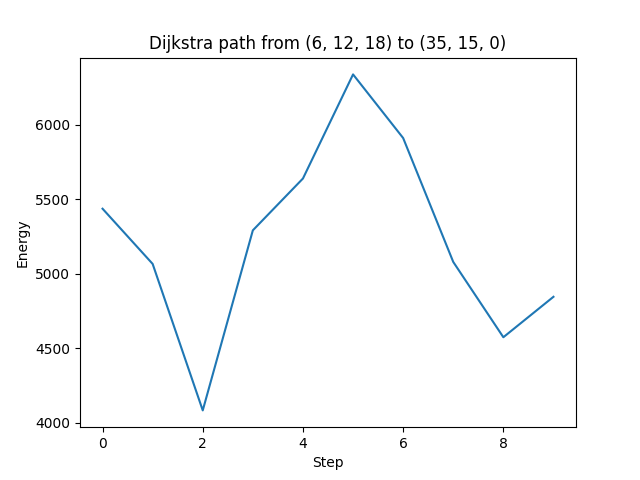

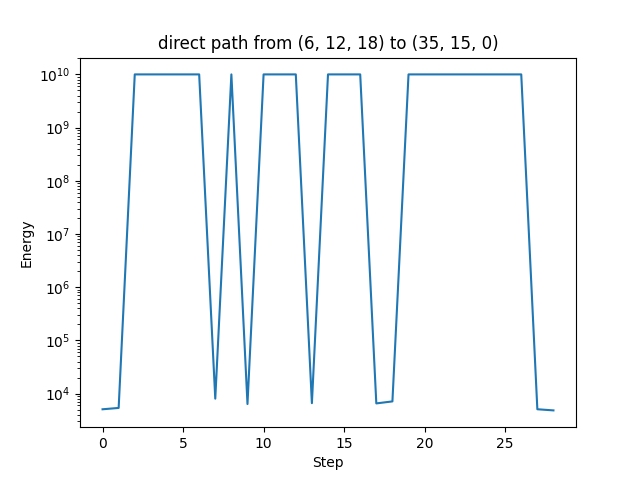

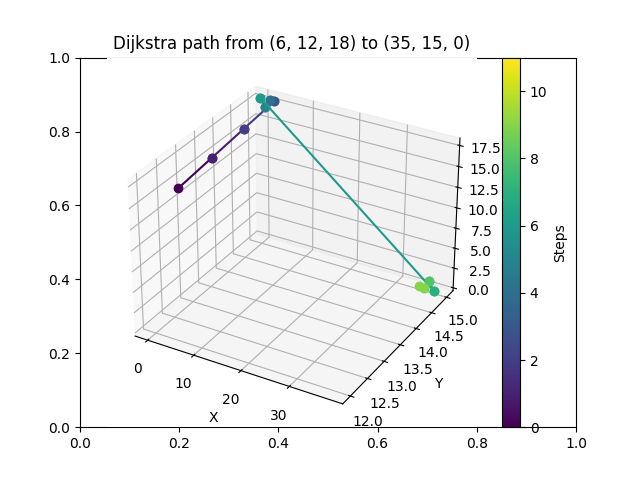

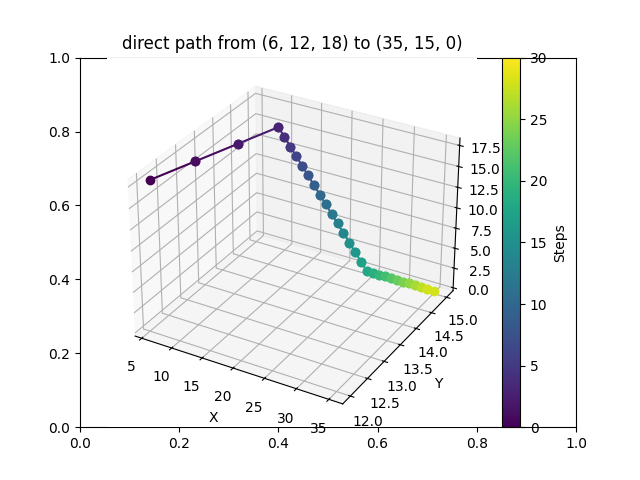

In [6]:
if path is not None:
    plots.energy_along_path(energy_path=path_energy)
    plt.title(f'Dijkstra path from {start_point} to {end_point}')

    plots.energy_along_path(energy_path=np.clip(dpath_energy, 0, 1e10))
    plt.title(f'direct path from {start_point} to {end_point}')
    plt.yscale('log')

    plots.path_on_grid(path=path)
    plt.title(f'Dijkstra path from {start_point} to {end_point}')

    plots.path_on_grid(path=dpath)
    plt.title(f'direct path from {start_point} to {end_point}')

else:
    print("No path found.")

In [7]:
# Look for the lowest-energy path that percolates the system.
# It is possible to set in which direction(s) the path has to percolate, with the `percolate_i` flags.

total_energy_cost, starting_point, best_perc_path, best_perc_path_energy = find_best_perc_path(
    F, peaks, percolate_x=True, percolate_y=False, percolate_z=False)

print(f"Total Energy required: {total_energy_cost}")
print(f"Starting Point: {starting_point}")
print(f"Best Path: {best_perc_path}")
print(f"Best Path Energy: {best_perc_path_energy}")

Total Energy required: 193306.3678530681
Starting Point: [36  0 14]
Best Path: [(36, 0, 14), (35, 0, 14), (34, 0, 13), (33, 0, 12), (32, 18, 12), (31, 17, 12), (30, 16, 12), (29, 15, 12), (28, 15, 11), (27, 16, 11), (26, 15, 10), (25, 15, 10), (24, 14, 9), (23, 13, 9), (22, 12, 8), (21, 12, 7), (20, 13, 8), (19, 13, 7), (18, 13, 8), (17, 13, 8), (16, 13, 9), (15, 13, 9), (14, 14, 9), (13, 15, 9), (12, 15, 8), (11, 14, 8), (10, 15, 9), (9, 15, 10), (8, 16, 11), (7, 17, 11), (6, 18, 12), (5, 18, 13), (4, 18, 14), (3, 18, 15), (2, 18, 15), (1, 18, 14), (0, 0, 14), (77, 1, 14), (76, 0, 14)]
Best Path Energy: [4476.638394656611, 5290.9343241786, 4317.424157659584, 4826.607221841744, 5349.182227326897, 5688.025227688533, 4745.518613609634, 5391.132266066318, 5272.623254150248, 4641.890584606367, 4534.886297804907, 6073.516646990458, 4540.715933293702, 6043.278636827778, 5402.056892971966, 5459.616601243905, 4968.250348074571, 4161.262428075799, 4042.209255391237, 4042.209255391237, 4208.6792

Text(0.5, 0.92, 'Best percolating path starts in [36  0 14]')

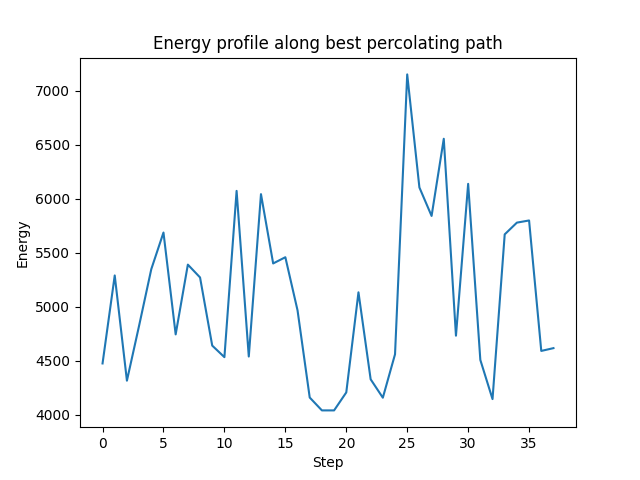

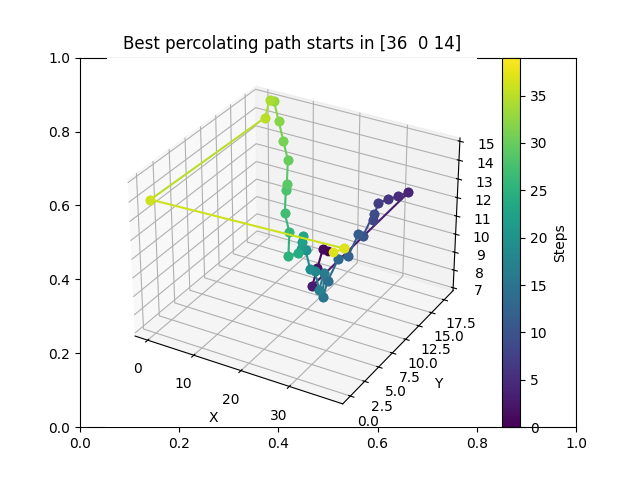

In [8]:
plots.energy_along_path(energy_path=best_perc_path_energy)
plt.title('Energy profile along best percolating path')

X, Y, Z = F.shape
wrapped_path = [(x % X, y % Y, z % Z) for x, y, z in best_perc_path]
plots.path_on_grid(path=wrapped_path)
plt.title(f'Best percolating path starts in {starting_point}')